In [11]:
pip install seaborn statsmodels scipy scikit-learn kafka-python plotly streamlit pmdarima

Note: you may need to restart the kernel to use updated packages.


In [12]:
# cell 1: imports and load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set(style="whitegrid", context="notebook", rc={"figure.figsize":(12,5)})


In [13]:
df = pd.read_csv("/Users/anshikashukla/Desktop/Classroomm Work/Operationalizing AI/Project/Kafka_air_quality/Real-Time-Air-Quality-Prediction-with-Apache-Kafka/AirQualityUCI.csv")

In [14]:
df.head(2)



,,,,,Date;Time;CO(GT);PT08.S1(CO);NMHC(GT);C6H6(GT);PT08.S2(NMHC);NOx(GT);PT08.S3(NOx);NO2(GT);PT08.S4(NO2);PT08.S5(O3);T;RH;AH;;
10/03/2004;18.00.00;2,6;1360;150;11,9;1046;166;1056;113;1692;1268;13,6;48,9;0,7578;;
10/03/2004;19.00.00;2;1292;112;9,4;955;103;1174;92;1559;972;13,3;47,7;0,7255;;,NaN


In [15]:
df.columns

Index(['Date;Time;CO(GT);PT08.S1(CO);NMHC(GT);C6H6(GT);PT08.S2(NMHC);NOx(GT);PT08.S3(NOx);NO2(GT);PT08.S4(NO2);PT08.S5(O3);T;RH;AH;;'], dtype='object')

In [16]:
df.tail(10)

Date;Time;CO(GT);PT08.S1(CO);NMHC(GT);C6H6(GT);PT08.S2(NMHC);NOx(GT);PT08.S3(NOx);NO2(GT);PT08.S4(NO2);PT08.S5(O3);T;RH;AH;;
;;;;;;;;;;;;;;;; NaN NaN NaN NaN                                                NaN                                                                          
                             NaN                                                NaN                                                                          
                             NaN                                                NaN                                                                          
                             NaN                                                NaN                                                                          
                             NaN                                                NaN                                                                          
                             NaN                                                NaN                                                                          
                             NaN                                                NaN                                                                          
                             NaN                                                NaN                                                                          
                             NaN                                                NaN                                                                          
                             NaN                                                NaN

In [17]:
# cell 2: load + basic cleaning
df = pd.read_csv("/Users/anshikashukla/Desktop/Classroomm Work/Operationalizing AI/Project/Kafka_air_quality/Real-Time-Air-Quality-Prediction-with-Apache-Kafka/AirQualityUCI.csv", sep=';', decimal=',', engine='python')
# drop empty Unnamed cols
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
# replace sentinel -200 with NaN
df = df.replace(-200, np.nan)

# parse datetime and set index
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'].str.replace('.', ':'), dayfirst=True, errors='coerce')
df = df.dropna(subset=['datetime']).set_index('datetime').sort_index()

# quick look at key pollutants (CO(GT), NOx(GT), C6H6(GT) for Benzene)
df[['CO(GT)','NOx(GT)','C6H6(GT)']].head()

,CO(GT),NOx(GT),C6H6(GT)
datetime,,,
2004-03-10 18:00:00,2.6,166.0,11.9
2004-03-10 19:00:00,2.0,103.0,9.4
2004-03-10 20:00:00,2.2,131.0,9.0
2004-03-10 21:00:00,2.2,172.0,9.2
2004-03-10 22:00:00,1.6,131.0,6.5


In [18]:
df.head(5)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,,,
2004-03-10 18:00:00,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [19]:
df.shape

(9357, 15)

## EDA

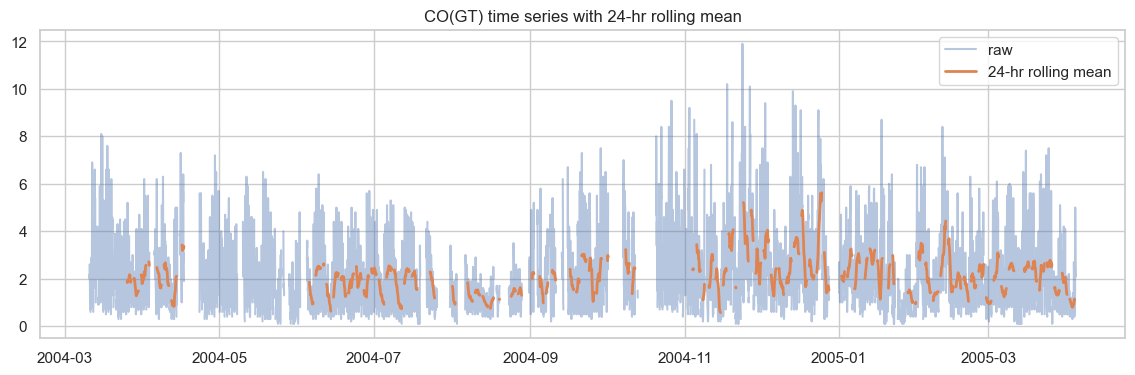

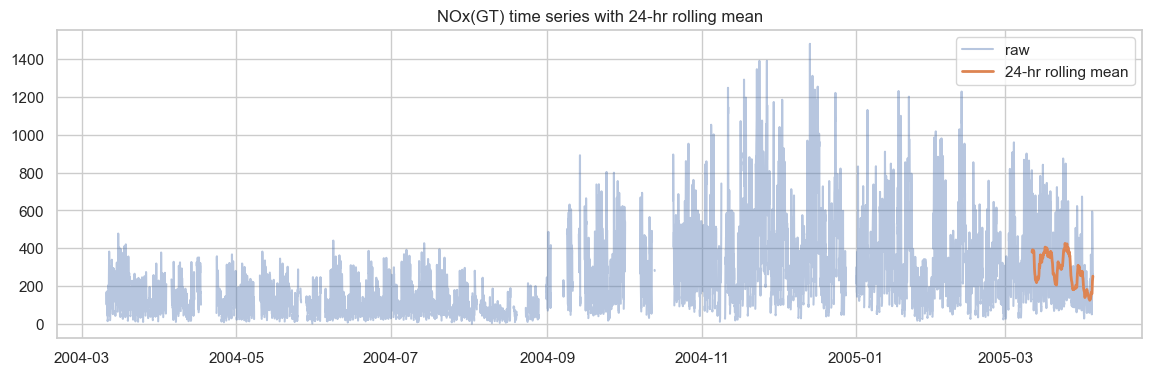

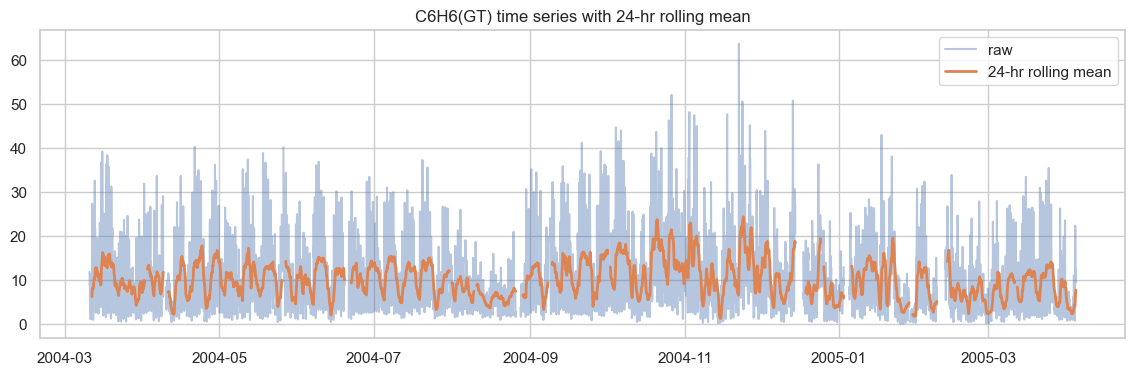

In [20]:
# plot raw series and rolling mean
for col in ['CO(GT)', 'NOx(GT)', 'C6H6(GT)']:
    plt.figure(figsize=(14,4))
    plt.plot(df.index, df[col], alpha=0.4, label='raw')
    plt.plot(df[col].rolling(24).mean(), label='24-hr rolling mean', linewidth=2)
    plt.title(f"{col} time series with 24-hr rolling mean")
    plt.legend()
    plt.show()

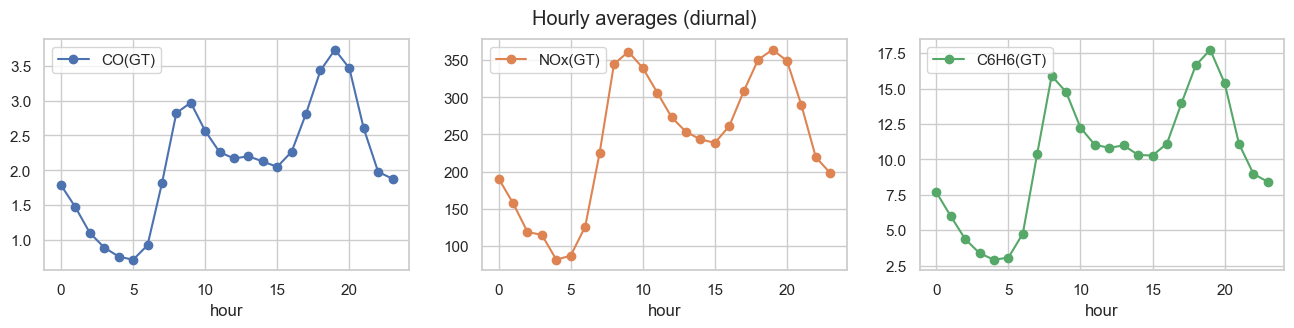

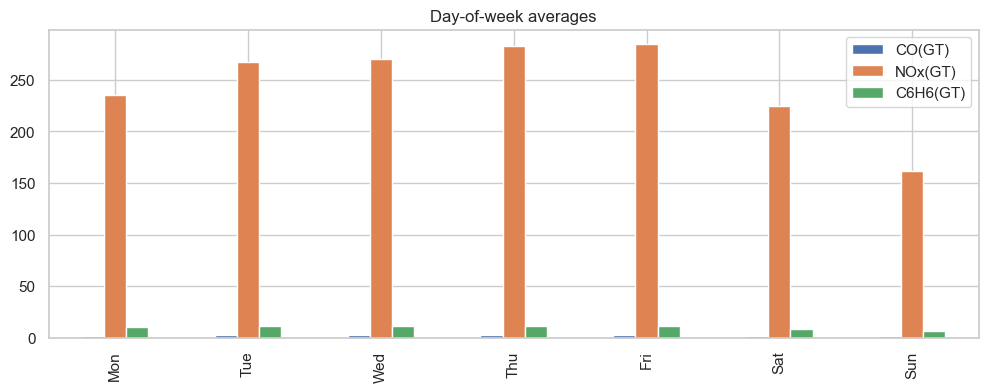

In [21]:
# create hour & dayofweek
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

# hourly average (diurnal cycle)
hourly = df.groupby('hour')[['CO(GT)','NOx(GT)','C6H6(GT)']].mean()
hourly.plot(subplots=True, layout=(1,3), figsize=(16,3), marker='o', title="Hourly averages (diurnal)")
plt.show()

# day-of-week effect
dow = df.groupby('dayofweek')[['CO(GT)','NOx(GT)','C6H6(GT)']].mean()
dow.index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
dow.plot(kind='bar', figsize=(12,4), title="Day-of-week averages")
plt.show()


Correlation matrix:
             CO(GT)   NOx(GT)  C6H6(GT)
CO(GT)    1.000000  0.786401  0.929991
NOx(GT)   0.786401  1.000000  0.718209
C6H6(GT)  0.929991  0.718209  1.000000


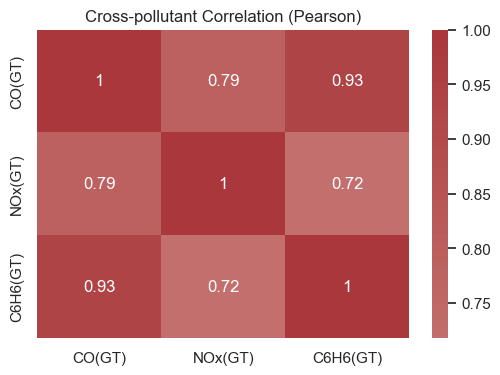

,CO(GT),NOx(GT),C6H6(GT)
CO(GT),NaN,0.0,0.0
NOx(GT),0.0,NaN,0.0
C6H6(GT),0.0,0.0,NaN


In [22]:
#Cross-pollutant correlation + significance testing

polls = df[['CO(GT)','NOx(GT)','C6H6(GT)']].dropna()
corr = polls.corr()
print("Correlation matrix:\n", corr)

# correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='vlag', center=0)
plt.title("Cross-pollutant Correlation (Pearson)")
plt.show()

# pairwise significance (p-values) using Pearson
from itertools import combinations
pvals = pd.DataFrame(index=polls.columns, columns=polls.columns, data=np.nan)
for a,b in combinations(polls.columns, 2):
    r, p = stats.pearsonr(polls[a], polls[b])
    pvals.loc[a,b] = p
    pvals.loc[b,a] = p
pvals


/var/folders/yt/r5wgtmb12n17g42ykp7839w00000gn/T/ipykernel_56754/383698405.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  series = df['CO(GT)'].dropna().asfreq('H')  # set hourly freq if possible; may contain NaNs
/var/folders/yt/r5wgtmb12n17g42ykp7839w00000gn/T/ipykernel_56754/383698405.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  plot_acf(series.fillna(method='ffill'), lags=72)


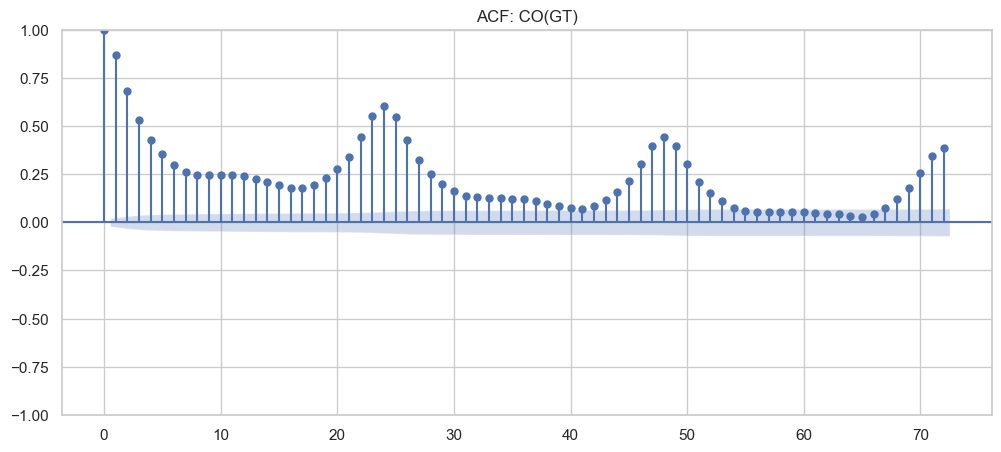

/var/folders/yt/r5wgtmb12n17g42ykp7839w00000gn/T/ipykernel_56754/383698405.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  plot_pacf(series.fillna(method='ffill'), lags=72, method='ywm')


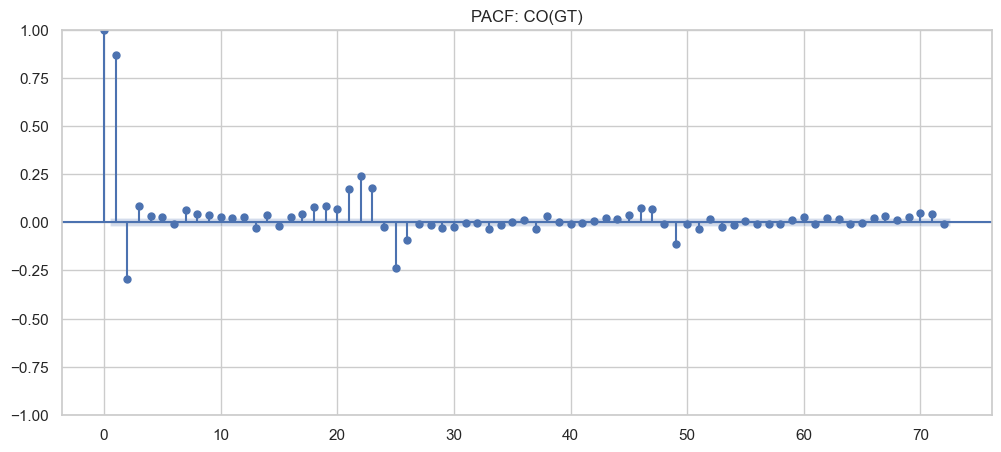

In [23]:
# choose target for time-dependence analysis
series = df['CO(GT)'].dropna().asfreq('H')  # set hourly freq if possible; may contain NaNs
# plot ACF/PACF
plot_acf(series.fillna(method='ffill'), lags=72)
plt.title("ACF: CO(GT)")
plt.show()
plot_pacf(series.fillna(method='ffill'), lags=72, method='ywm')
plt.title("PACF: CO(GT)")
plt.show()


/var/folders/yt/r5wgtmb12n17g42ykp7839w00000gn/T/ipykernel_56754/1188364184.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_filled = series.fillna(method='ffill').fillna(method='bfill')


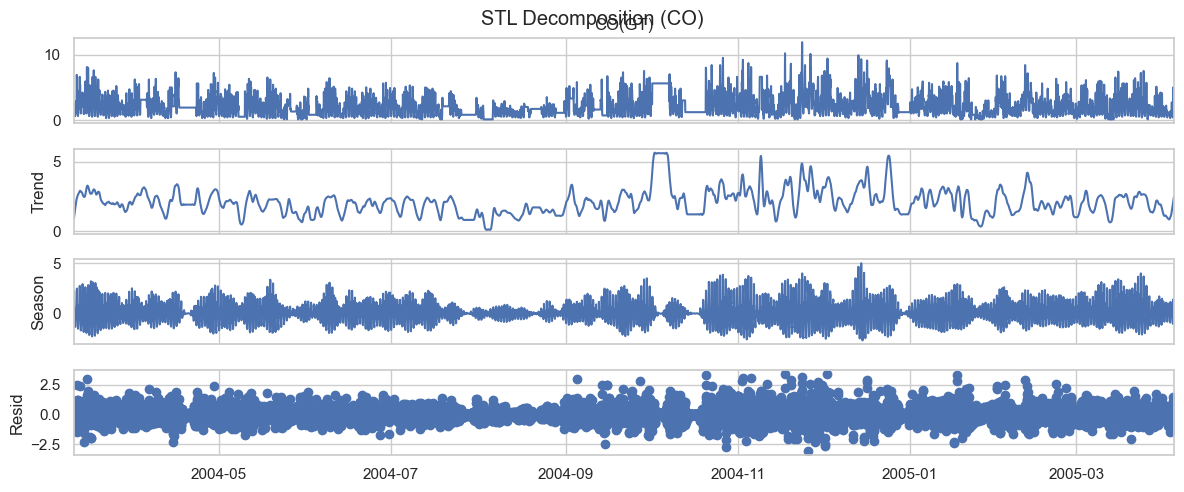

In [24]:
# use STL for robust decomposition (works with missing -> fill short gaps)
series_filled = series.fillna(method='ffill').fillna(method='bfill')
stl = STL(series_filled, period=24)   # daily seasonality for hourly data
res = stl.fit()
fig = res.plot()
plt.suptitle("STL Decomposition (CO)")
plt.show()


# Anomaly detection (simple & explainable)

Two simple detectors:

Z-score (global)

Rolling IQR (local)

Global anomalies count: 132
Local anomalies count: 515


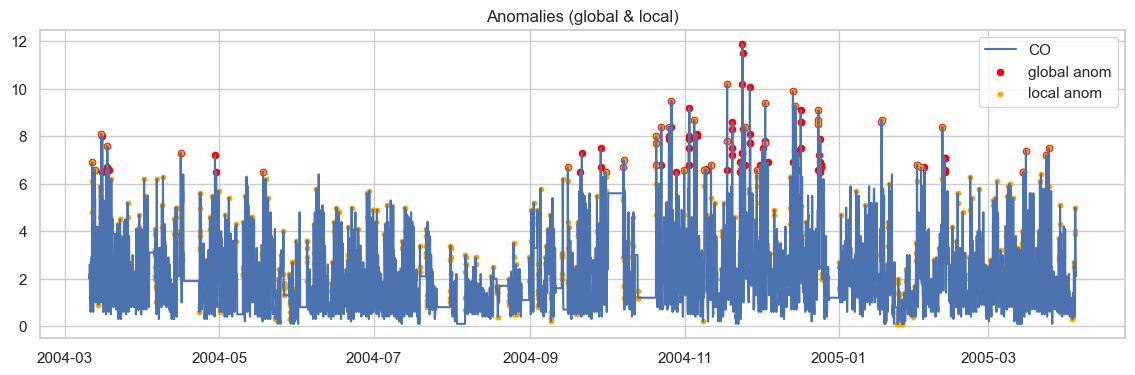

In [25]:
s = series_filled
# global z-score
z = np.abs((s - s.mean())/s.std())
global_anoms = s[z > 3]

# rolling IQR (local)
roll_median = s.rolling(window=24, min_periods=6).median()
roll_q1 = s.rolling(window=24, min_periods=6).quantile(0.25)
roll_q3 = s.rolling(window=24, min_periods=6).quantile(0.75)
iqr = roll_q3 - roll_q1
local_upper = roll_q3 + 1.5 * iqr
local_lower = roll_q1 - 1.5 * iqr
local_anoms = s[(s > local_upper) | (s < local_lower)]

print("Global anomalies count:", len(global_anoms))
print("Local anomalies count:", len(local_anoms))

# plot anomalies on series
plt.figure(figsize=(14,4))
plt.plot(s.index, s, label='CO')
plt.scatter(global_anoms.index, global_anoms, color='red', label='global anom', s=20)
plt.scatter(local_anoms.index, local_anoms, color='orange', label='local anom', s=10)
plt.legend()
plt.title("Anomalies (global & local)")
plt.show()


# Statistical tests & significance

test if mean CO differs between weekdays and weekends (t-test / Mann–Whitney)

The null hypothesis (H₀) = there is no difference in CO levels between weekdays and weekends.

The alternative hypothesis (H₁) = there is a difference.


In [26]:
weekday_co = df[df['dayofweek'] < 5]['CO(GT)'].dropna()
weekend_co = df[df['dayofweek'] >= 5]['CO(GT)'].dropna()
tstat, pval = stats.ttest_ind(weekday_co, weekend_co, equal_var=False, nan_policy='omit')
print("Weekday vs Weekend CO: t =", tstat, "p =", pval)


Weekday vs Weekend CO: t = 23.396789437198567 p = 4.007328819983175e-116


#### t= 23.40 → huge test statistic, meaning the difference between the two groups (weekday vs weekend CO) is much larger than expected by chance.

#### p ≈ 4.0e-116 → effectively zero. This is way below any standard significance threshold (0.05, 0.01, even 1e-10).

#### So we reject H₀ with very high confidence: CO levels are significantly different between weekdays and weekends.

# ************

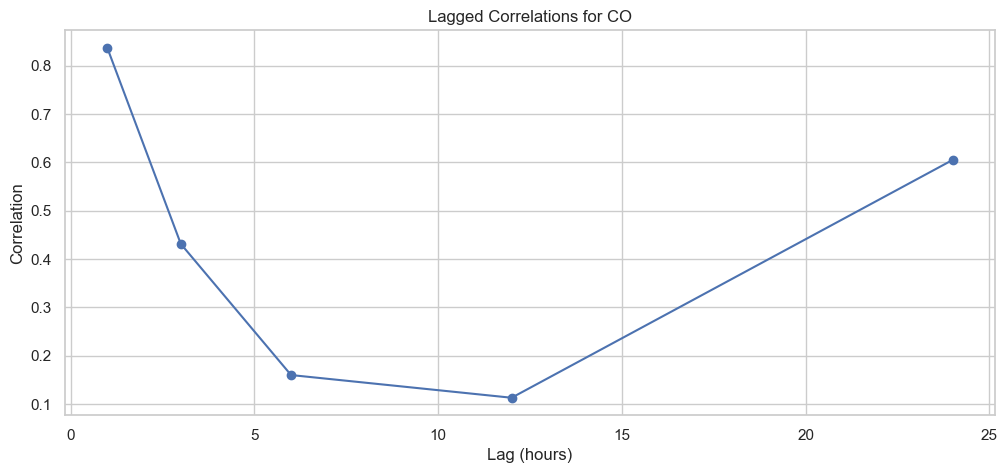

In [27]:
for lag in [1, 3, 6, 12, 24]:  # hours
    df[f'CO(GT)_lag_{lag}'] = df['CO(GT)'].shift(lag)
    
# Plot lag vs current correlation
lags = [1,3,6,12,24]
correlations = [df['CO(GT)'].corr(df[f'CO(GT)_lag_{lag}']) for lag in lags]
plt.plot(lags, correlations, marker='o')
plt.xlabel("Lag (hours)")
plt.ylabel("Correlation")
plt.title("Lagged Correlations for CO")
plt.show()


<Axes: xlabel='datetime'>

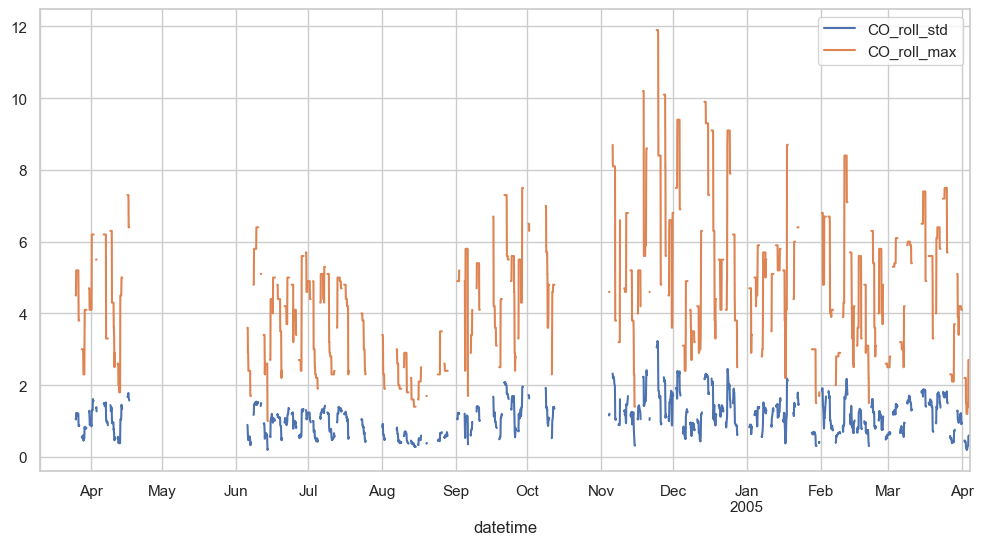

In [28]:
rolling_window = 24  # hours
df['CO_roll_std'] = df['CO(GT)'].rolling(rolling_window).std()
df['CO_roll_max'] = df['CO(GT)'].rolling(rolling_window).max()

df[['CO_roll_std','CO_roll_max']].plot(figsize=(12,6))


<Axes: xlabel='CO(GT)', ylabel='Count'>

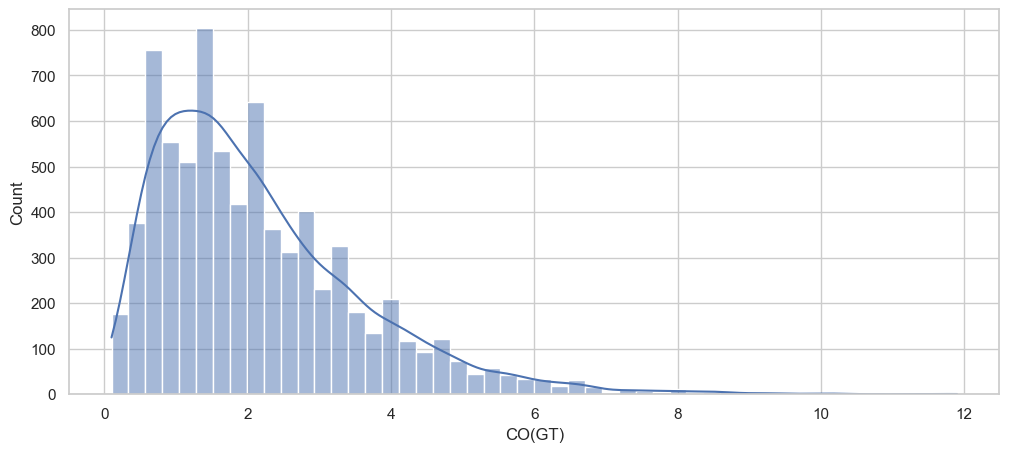

In [29]:
import seaborn as sns

sns.histplot(df['CO(GT)'].dropna(), kde=True, bins=50)


<Axes: xlabel='CO(GT)'>

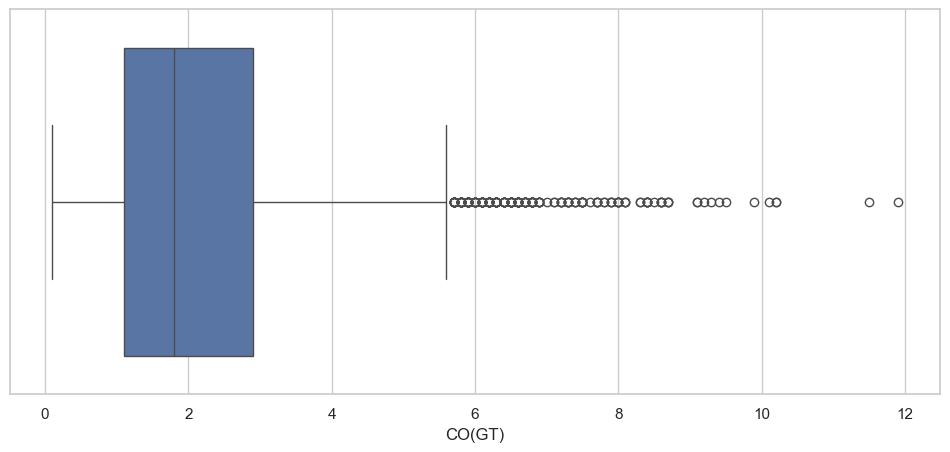

In [30]:
sns.boxplot(x=df['CO(GT)'])

In [31]:
threshold = df['CO(GT)'].quantile(0.99)
extremes = df[df['CO(GT)'] > threshold]


In [32]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'hour', 'dayofweek', 'CO(GT)_lag_1',
       'CO(GT)_lag_3', 'CO(GT)_lag_6', 'CO(GT)_lag_12', 'CO(GT)_lag_24',
       'CO_roll_std', 'CO_roll_max'],
      dtype='object')

In [33]:
df.head(5)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),...,AH,hour,dayofweek,CO(GT)_lag_1,CO(GT)_lag_3,CO(GT)_lag_6,CO(GT)_lag_12,CO(GT)_lag_24,CO_roll_std,CO_roll_max
datetime,,,,,,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,...,0.7578,18,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 19:00:00,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,...,0.7255,19,2,2.6,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 20:00:00,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,...,0.7502,20,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 21:00:00,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,...,0.7867,21,2,2.2,2.6,NaN,NaN,NaN,NaN,NaN
2004-03-10 22:00:00,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,...,0.7888,22,2,2.2,2.0,NaN,NaN,NaN,NaN,NaN


In [34]:
df.shape

(9357, 24)

In [35]:
df.tail(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),...,AH,hour,dayofweek,CO(GT)_lag_1,CO(GT)_lag_3,CO(GT)_lag_6,CO(GT)_lag_12,CO(GT)_lag_24,CO_roll_std,CO_roll_max
datetime,,,,,,,,,,,,,,,,,,,,,
2005-04-04 05:00:00,04/04/2005,05.00.00,0.5,888.0,NaN,1.3,528.0,77.0,1077.0,53.0,...,0.7550,5,0,NaN,0.5,1.2,1.4,0.3,NaN,NaN
2005-04-04 06:00:00,04/04/2005,06.00.00,1.1,1031.0,NaN,4.4,730.0,182.0,760.0,93.0,...,0.7531,6,0,0.5,0.4,0.9,1.2,0.4,NaN,NaN
2005-04-04 07:00:00,04/04/2005,07.00.00,4.0,1384.0,NaN,17.4,1221.0,594.0,470.0,155.0,...,0.7446,7,0,1.1,NaN,0.6,2.7,0.6,NaN,NaN
2005-04-04 08:00:00,04/04/2005,08.00.00,5.0,1446.0,NaN,22.4,1362.0,586.0,415.0,174.0,...,0.7553,8,0,4.0,0.5,0.5,2.5,0.7,NaN,NaN
2005-04-04 09:00:00,04/04/2005,09.00.00,3.9,1297.0,NaN,13.6,1102.0,523.0,507.0,187.0,...,0.7487,9,0,5.0,1.1,0.4,1.5,1.2,NaN,NaN
2005-04-04 10:00:00,04/04/2005,10.00.00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,...,0.7568,10,0,3.9,4.0,NaN,1.6,1.4,NaN,NaN
2005-04-04 11:00:00,04/04/2005,11.00.00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,...,0.7119,11,0,3.1,5.0,0.5,1.2,1.3,NaN,NaN
2005-04-04 12:00:00,04/04/2005,12.00.00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,...,0.6406,12,0,2.4,3.9,1.1,0.9,1.4,NaN,NaN
2005-04-04 13:00:00,04/04/2005,13.00.00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,...,0.5139,13,0,2.4,3.1,4.0,0.6,1.0,NaN,NaN


In [36]:
df.head(4)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),...,AH,hour,dayofweek,CO(GT)_lag_1,CO(GT)_lag_3,CO(GT)_lag_6,CO(GT)_lag_12,CO(GT)_lag_24,CO_roll_std,CO_roll_max
datetime,,,,,,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,...,0.7578,18,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 19:00:00,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,...,0.7255,19,2,2.6,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 20:00:00,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,...,0.7502,20,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 21:00:00,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,...,0.7867,21,2,2.2,2.6,NaN,NaN,NaN,NaN,NaN


## Additional features

In [37]:
TARGET = "CO(GT)"
# Time-based features
  # Ensure datetime exists
if 'datetime' not in df.columns:
        df['datetime'] = pd.to_datetime(
            df['Date'] + ' ' + df['Time'].str.replace('.', ':', regex=False),
            format='%d/%m/%Y %H:%M:%S'
        )
df['month'] = df['datetime'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [38]:
# Rolling mean and std features
df[f"{TARGET}_rollmean_3"] = df[TARGET].rolling(window=3, min_periods=1).mean()
df[f"{TARGET}_rollstd_3"] = df[TARGET].rolling(window=3, min_periods=1).std().fillna(0)
df[f"{TARGET}_rollmean_24"] = df[TARGET].rolling(window=24, min_periods=1).mean()
df[f"{TARGET}_rollstd_24"] = df[TARGET].rolling(window=24, min_periods=1).std().fillna(0)

    

In [39]:
df.isna().any(axis=1).sum()

9101

In [40]:
df.head(4)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),...,CO_roll_std,CO_roll_max,datetime,month,hour_sin,hour_cos,CO(GT)_rollmean_3,CO(GT)_rollstd_3,CO(GT)_rollmean_24,CO(GT)_rollstd_24
datetime,,,,,,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,...,NaN,NaN,2004-03-10 18:00:00,3,-1.000000,-1.836970e-16,2.600000,0.000000,2.600000,0.000000
2004-03-10 19:00:00,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,...,NaN,NaN,2004-03-10 19:00:00,3,-0.965926,2.588190e-01,2.300000,0.424264,2.300000,0.424264
2004-03-10 20:00:00,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,...,NaN,NaN,2004-03-10 20:00:00,3,-0.866025,5.000000e-01,2.266667,0.305505,2.266667,0.305505
2004-03-10 21:00:00,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,...,NaN,NaN,2004-03-10 21:00:00,3,-0.707107,7.071068e-01,2.133333,0.115470,2.250000,0.251661


In [41]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'hour', 'dayofweek', 'CO(GT)_lag_1',
       'CO(GT)_lag_3', 'CO(GT)_lag_6', 'CO(GT)_lag_12', 'CO(GT)_lag_24',
       'CO_roll_std', 'CO_roll_max', 'datetime', 'month', 'hour_sin',
       'hour_cos', 'CO(GT)_rollmean_3', 'CO(GT)_rollstd_3',
       'CO(GT)_rollmean_24', 'CO(GT)_rollstd_24'],
      dtype='object')

In [42]:
df.head

<bound method NDFrame.head of                            Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  \
datetime                                                                   
2004-03-10 18:00:00  10/03/2004  18.00.00     2.6       1360.0     150.0   
2004-03-10 19:00:00  10/03/2004  19.00.00     2.0       1292.0     112.0   
2004-03-10 20:00:00  10/03/2004  20.00.00     2.2       1402.0      88.0   
2004-03-10 21:00:00  10/03/2004  21.00.00     2.2       1376.0      80.0   
2004-03-10 22:00:00  10/03/2004  22.00.00     1.6       1272.0      51.0   
...                         ...       ...     ...          ...       ...   
2005-04-04 10:00:00  04/04/2005  10.00.00     3.1       1314.0       NaN   
2005-04-04 11:00:00  04/04/2005  11.00.00     2.4       1163.0       NaN   
2005-04-04 12:00:00  04/04/2005  12.00.00     2.4       1142.0       NaN   
2005-04-04 13:00:00  04/04/2005  13.00.00     2.1       1003.0       NaN   
2005-04-04 14:00:00  04/04/2005  14.00.00     2.2       10

In [43]:
#df = df.dropna().reset_index(drop=True)

In [44]:
df.shape

(9357, 32)

In [45]:
nan_counts = df.isna().sum()
print(nan_counts[nan_counts > 0])

CO(GT)                1683
PT08.S1(CO)            366
NMHC(GT)              8443
C6H6(GT)               366
PT08.S2(NMHC)          366
NOx(GT)               1639
PT08.S3(NOx)           366
NO2(GT)               1642
PT08.S4(NO2)           366
PT08.S5(O3)            366
T                      366
RH                     366
AH                     366
CO(GT)_lag_1          1684
CO(GT)_lag_3          1686
CO(GT)_lag_6          1689
CO(GT)_lag_12         1694
CO(GT)_lag_24         1706
CO_roll_std           5616
CO_roll_max           5616
CO(GT)_rollmean_3     1454
CO(GT)_rollmean_24     944
dtype: int64


In [46]:
# Drop from holdout DataFrame
df = df.drop(columns=['NMHC(GT)','PT08.S2(NMHC)'], errors='ignore')

In [47]:
df.to_csv('air_quality_cleaned.csv', index=True)

In [48]:
# This determines the index at the 90% mark of the dataset.
split_point = int(len(df) * 0.9)

# The training/testing set is the first 90% of the data
training_df = df.iloc[:split_point]

# The holdout set is the final 10% of the data
holdout_df = df.iloc[split_point:]

# The index=False argument prevents pandas from writing the DataFrame index as a column.
training_df.to_csv('training_data.csv', index=True)

print("\nSplit complete!")
print(f"'{'training_data.csv'}' created with {len(training_df)} rows (90%).")
print(f"'{'holdout_data.csv'}' created with {len(holdout_df)} rows (10%).")


Split complete!
'training_data.csv' created with 8421 rows (90%).
'holdout_data.csv' created with 936 rows (10%).


In [49]:
holdout_df.shape

(936, 30)

In [50]:
holdout_df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH', 'hour', 'dayofweek', 'CO(GT)_lag_1', 'CO(GT)_lag_3',
       'CO(GT)_lag_6', 'CO(GT)_lag_12', 'CO(GT)_lag_24', 'CO_roll_std',
       'CO_roll_max', 'datetime', 'month', 'hour_sin', 'hour_cos',
       'CO(GT)_rollmean_3', 'CO(GT)_rollstd_3', 'CO(GT)_rollmean_24',
       'CO(GT)_rollstd_24'],
      dtype='object')

In [51]:
print("Handling NaN values...")

    # 1. Drop rows where target itself is missing (cannot train without target)
holdout_df = holdout_df.dropna(subset=[TARGET]).reset_index(drop=True)

    # 2. Impute sensor/environmental features with median
sensor_cols = ['PT08.S1(CO)', 'C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)',
                   'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
                   'T', 'RH', 'AH']
for col in sensor_cols:
        median_val = holdout_df[col].median()
        holdout_df[col] = holdout_df[col].fillna(median_val)

    # 3. Impute lag/rolling features with forward-fill then backward-fill
lag_roll_cols = ['CO(GT)_lag_1','CO(GT)_lag_3','CO(GT)_lag_6','CO(GT)_lag_12',
                     'CO(GT)_lag_24','CO_roll_std','CO_roll_max','CO(GT)_rollmean_3','CO(GT)_rollmean_24']
holdout_df[lag_roll_cols] = holdout_df[lag_roll_cols].ffill().bfill()

    # Optional: check if any NaNs remain
if holdout_df.isna().sum().sum() > 0:
        print("Warning: There are still NaNs remaining in the dataset")
        print(holdout_df.isna().sum()[holdout_df.isna().sum() > 0])

Handling NaN values...


In [52]:
holdout_df.tail(4)

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,CO_roll_std,CO_roll_max,datetime,month,hour_sin,hour_cos,CO(GT)_rollmean_3,CO(GT)_rollstd_3,CO(GT)_rollmean_24,CO(GT)_rollstd_24
909,04/04/2005,11.00.00,2.4,1163.0,11.4,353.0,604.0,179.0,1264.0,1269.0,...,0.603117,2.7,2005-04-04 11:00:00,4,2.588190e-01,-0.965926,3.133333,0.750555,1.752174,1.244212
910,04/04/2005,12.00.00,2.4,1142.0,12.4,293.0,603.0,175.0,1241.0,1092.0,...,0.603117,2.7,2005-04-04 12:00:00,4,1.224647e-16,-1.000000,2.633333,0.404145,1.795652,1.248810
911,04/04/2005,13.00.00,2.1,1003.0,9.5,235.0,702.0,156.0,1041.0,770.0,...,0.603117,2.7,2005-04-04 13:00:00,4,-2.588190e-01,-0.965926,2.300000,0.173205,1.843478,1.237970
912,04/04/2005,14.00.00,2.2,1071.0,11.9,265.0,654.0,168.0,1129.0,816.0,...,0.603117,2.7,2005-04-04 14:00:00,4,-5.000000e-01,-0.866025,2.233333,0.152753,1.895652,1.226035


In [53]:
holdout_df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH', 'hour', 'dayofweek', 'CO(GT)_lag_1', 'CO(GT)_lag_3',
       'CO(GT)_lag_6', 'CO(GT)_lag_12', 'CO(GT)_lag_24', 'CO_roll_std',
       'CO_roll_max', 'datetime', 'month', 'hour_sin', 'hour_cos',
       'CO(GT)_rollmean_3', 'CO(GT)_rollstd_3', 'CO(GT)_rollmean_24',
       'CO(GT)_rollstd_24'],
      dtype='object')

In [54]:
holdout_df.to_csv('holdout_data.csv', index=True)

In [55]:
training_df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH', 'hour', 'dayofweek', 'CO(GT)_lag_1', 'CO(GT)_lag_3',
       'CO(GT)_lag_6', 'CO(GT)_lag_12', 'CO(GT)_lag_24', 'CO_roll_std',
       'CO_roll_max', 'datetime', 'month', 'hour_sin', 'hour_cos',
       'CO(GT)_rollmean_3', 'CO(GT)_rollstd_3', 'CO(GT)_rollmean_24',
       'CO(GT)_rollstd_24'],
      dtype='object')

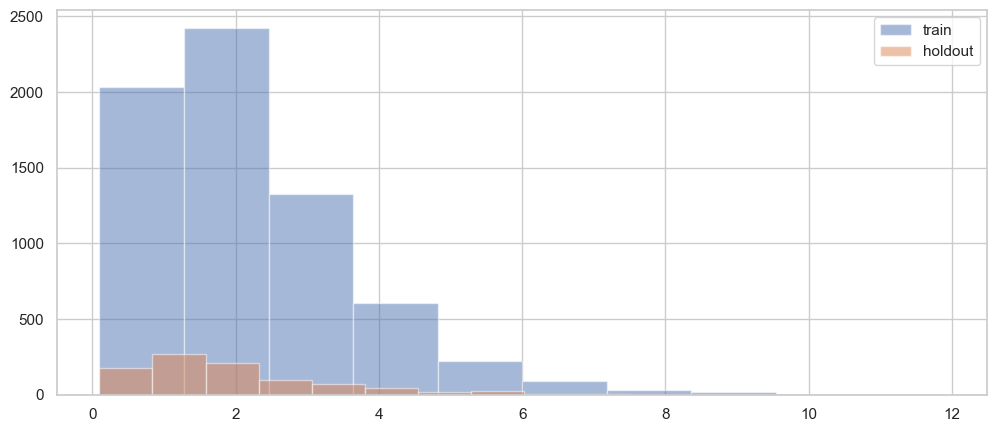

In [56]:
training_df["CO(GT)"].hist(alpha=0.5, label="train")
holdout_df["CO(GT)"].hist(alpha=0.5, label="holdout")
plt.legend()


## We can see that since we are taking the last 10% of our data as holdout, we see the sesonal trends here where we have a lot more values in the 0 - 1.5 range than our training data which has higher data points with value =2   